# Team Members

1. Deepan Chakravarthi Padmanabhan
2. Mihir Mulye

# Assignment 5
- Gather a dataset for humanoid robot
- Finetune DenseNet for your custom dataset of humanoid robot classification (Binary classification Robot/NoRobot)
- Use LR Scheduler of your choice!
- Extra point:
    include Mixup data augmentation for your model

In [1]:
from __future__ import print_function, division

import typing 
import numpy as np
import random as rand
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import time
import io
import os
import copy

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import torchvision.datasets as dsets
from torch.utils.data.sampler import SubsetRandomSampler
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

plt.ion()   # interactive mode

print("PyTorch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)

PyTorch version:  1.7.0+cu101
Torchvision version:  0.8.1+cu101


In [2]:
# !wget https://download.pytorch.org/tutorial/hymenoptera_data.zip #Download the data from
# !unzip hymenoptera_data.zip #extract it to the current directory.
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/final_data.tar.gz .

In [4]:
!tar -xvf final_data.tar.gz

._final_data
final_data/
final_data/._.DS_Store
final_data/.DS_Store
final_data/._train
final_data/train/
final_data/._val
final_data/val/
final_data/val/._.DS_Store
final_data/val/.DS_Store
final_data/val/._norobot
final_data/val/norobot/
final_data/val/._robot
final_data/val/robot/
final_data/val/robot/._val-robot69.jpg
final_data/val/robot/val-robot69.jpg
final_data/val/robot/._val-robot41.jpg
final_data/val/robot/val-robot41.jpg
final_data/val/robot/._val-robot55.jpg
final_data/val/robot/val-robot55.jpg
final_data/val/robot/._val-robot8.jpg
final_data/val/robot/val-robot8.jpg
final_data/val/robot/._val-robot82.jpg
final_data/val/robot/val-robot82.jpg
final_data/val/robot/._val-robot96.jpg
final_data/val/robot/val-robot96.jpg
final_data/val/robot/._val-robot97.jpg
final_data/val/robot/val-robot97.jpg
final_data/val/robot/._val-robot83.jpg
final_data/val/robot/val-robot83.jpg
final_data/val/robot/._val-robot9.jpg
final_data/val/robot/val-robot9.jpg
final_data/val/robot/._val-robot54.

In [5]:
!cd final_data/val/norobot/; rm -rf ._*
!cd final_data/val/robot/; rm -rf ._*
!cd final_data/train/norobot/; rm -rf ._*
!cd final_data/train/robot/; rm -rf ._*

In [6]:
if torch.cuda.is_available():
    device_under_use = torch.device("cuda")
else:
    device_under_use = torch.device("cpu")
print(device_under_use)

cuda


In [7]:
def accuracy_metric(Y: np.ndarray,
                    predictions: np.ndarray,
                   ) -> float:
    """
    Parameters:
    -----------
    Y: np.ndarray
        True labels in the test set
    predictions: np.ndarray
        Predictions on test set
        
    Return:
    -------
    accuracy: float
        Accuracy metric on the Y and predictions provided to the function 
    
    """
    correct = 0
    for i in range(len(Y)):
        if Y[i] == predictions[i]:
            correct += 1
    accuracy = correct / float(len(Y)) * 100.0
    return accuracy

def metrics(Y: np.ndarray,
            predictions: np.ndarray,
            print_metrics: bool = False) -> typing.Tuple:
    """
    Calculates the accuracy and prints the confusion matrix for the true labels and predictions provided
    Parameters:
    -----------
    Y: np.ndarray
        True labels in the test set
    predictions: np.ndarray
        Predictions on test set
    print_metrics: bool
        Flag to allow printing of the metrics calculated
    
    Return:
    -------
    accuracy: float
        Accuracy for the labels and predictions provided
    df_confusion: pandas dataframe
        Confusion matrix for the labels and predictions provided
        
    """
    accuracy = accuracy_metric(Y, predictions)
    df_confusion = pd.crosstab(Y, predictions, rownames=['Actual'], colnames=['Predicted'], margins=True)
    
    if print_metrics:
        print("Accuracy: ", accuracy)
        print("Confusion matrix: \n", df_confusion)
        
    return accuracy, df_confusion


In [8]:
def plot_training_graph(train_data: typing.List, 
                        val_data: typing.List,
                        label: bool
                       ) -> None:
    
    """
    Visualize the training/validation loss/accuracy of the model
    
    Parameters:
    -----------
    train_data: typing.List
        Train loss/accuracy per epoch
    val_data: typing.List,
        Validation loss/accuracy per epoch
    label: bool
        Flag stating whether loss/accuracy
    
    """
    if label == 'accuracy':
        train_label = 'Training accuracy'
        val_label = 'Validation accuracy'
        x_label = 'Epoch'
        y_label = 'Accuracy'
        title = 'Epoch vs Accuracy'
    else:
        train_label = 'Training loss'
        val_label = 'Validation loss'
        x_label = 'Epoch'
        y_label = 'Loss'
        title = 'Epoch vs Loss'
    fig = plt.figure(figsize=(12,12))
    plt.plot(train_data, c='k', label=train_label)
    plt.plot(val_data, c='m', label=val_label)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()

In [9]:
def set_parameter_requires_grad(model: torch.nn, 
                                feature_extracting: bool,
                               ) -> None:
  """
  Parameters:
  -----------
  model: torch.nn
    Model selected for finetuning - Densenet
  feature_extracting: bool
    Flag to set the weight variables requires_grads argument to True

  """
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

In [10]:
def get_model(num_classes, feature_extract=False, use_pretrained=True):
  """
  Helper to get model for fine tuning or feature extraction
  
  Parameters:
  -----------
  num_classes: int
    Number of classes for the final output layer
  feature_extract: bool
    Flag for feature extracting.
    When False, the model is finetuned by starting
    from the pretrained CNN and updating all the model parameters for the 
    new task. 
    when True, we only update the reshaped layer params and the backbone 
    pretrained CNN acts as a fixed feature-extractor.
  use_pretrained: bool
    Use pretrained model for finetuning / feature extraction. 
    When False, model is trained from scratch
    When True, model is used for finetuning / as feature extractor

  Return:
  -------
  model: torch.nn
    Model selected for finetuning / use as feature extractor
  input_size: int
    input size of the model

  """
  model_ft = models.densenet121(pretrained=use_pretrained)
  set_parameter_requires_grad(model_ft, feature_extract)
  num_ftrs = model_ft.classifier.in_features
  model_ft.classifier = nn.Linear(num_ftrs, num_classes)
  input_size = 224
  return model_ft, input_size

In [11]:
feature_extract = False
model_ft, input_size = get_model(num_classes=2, feature_extract=feature_extract, use_pretrained=True)
model_ft = model_ft.to(device_under_use)
print(model_ft)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [12]:
# Showing all trainable layers
# If feature_extract is True, then only the FC layers will be trained again.
# Since, it is finetuning, all the layers are initialized with the pretrained model.
params_to_update = model_ft.parameters()
print('Params to learn: ')
if feature_extract:
  params_to_update = []
  for name, param in model_ft.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
      print('\t', name)
else:
  for name, param in model_ft.named_parameters():
    if param.requires_grad == True:
      print('\t', name)
      

Params to learn: 
	 features.conv0.weight
	 features.norm0.weight
	 features.norm0.bias
	 features.denseblock1.denselayer1.norm1.weight
	 features.denseblock1.denselayer1.norm1.bias
	 features.denseblock1.denselayer1.conv1.weight
	 features.denseblock1.denselayer1.norm2.weight
	 features.denseblock1.denselayer1.norm2.bias
	 features.denseblock1.denselayer1.conv2.weight
	 features.denseblock1.denselayer2.norm1.weight
	 features.denseblock1.denselayer2.norm1.bias
	 features.denseblock1.denselayer2.conv1.weight
	 features.denseblock1.denselayer2.norm2.weight
	 features.denseblock1.denselayer2.norm2.bias
	 features.denseblock1.denselayer2.conv2.weight
	 features.denseblock1.denselayer3.norm1.weight
	 features.denseblock1.denselayer3.norm1.bias
	 features.denseblock1.denselayer3.conv1.weight
	 features.denseblock1.denselayer3.norm2.weight
	 features.denseblock1.denselayer3.norm2.bias
	 features.denseblock1.denselayer3.conv2.weight
	 features.denseblock1.denselayer4.norm1.weight
	 features.d

In [13]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'final_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
print("Size of the train set: ", dataset_sizes['train'])
print("Size of the validation set: ", dataset_sizes['val'])
num_classes = len(class_names)

Size of the train set:  246
Size of the validation set:  210


In [14]:
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
# Decay LR by a factor of 0.1 every 7 epochs
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


In [15]:
def evaluation(test_loader:  torch.utils.data.DataLoader,
               model: torch.nn,
               criterion,
              ) -> typing.Tuple:
    
    """
    Testing module
    
    Parameters:
    -----------
    test_loader:  torch.utils.data.DataLoader
        Validation data is used for testing due to the availability 
        of less data in this study
    model: torch.nn
        Model
    
    Return:
    -------
    avg_test_loss: float
        Average loss for the test set
    accuracy: float
        Accuracy for the labels and predictions provided
    df_confusion: pandas dataframe
        Confusion matrix for the labels and predictions provided
        
    """
    
    model.eval()
    
    test_len = len(test_loader.dataset)
    print('Size of test data: ', test_len)
    
    test_loss = 0
    confusion_matrix = np.zeros((11, 11))
    accuracy_list = []
    y_pred = []
    y_true = []
    
    for images, labels in test_loader:
    
        images = images.to(device_under_use)
        labels = labels.to(device_under_use)
        
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        test_loss += loss.detach().item()
        
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        
        labels_list = labels.tolist()
        y_true.extend(labels_list)
        
    accuracy, df_confusion = metrics(np.array(y_true), np.array(y_pred), True)
    avg_test_loss = test_loss / test_len
    return avg_test_loss, accuracy, df_confusion

# Binary classification of Robot / Norobot without Mixup data augmentation

Epoch 0/24
----------
train Loss: 0.6230 Acc: 0.6585
val Loss: 0.4514 Acc: 0.8857

Epoch 1/24
----------
train Loss: 0.4100 Acc: 0.8943
val Loss: 0.2325 Acc: 0.9429

Epoch 2/24
----------
train Loss: 0.3047 Acc: 0.9065
val Loss: 0.1380 Acc: 0.9762

Epoch 3/24
----------
train Loss: 0.1997 Acc: 0.9472
val Loss: 0.0938 Acc: 0.9857

Epoch 4/24
----------
train Loss: 0.1685 Acc: 0.9309
val Loss: 0.0761 Acc: 0.9905

Epoch 5/24
----------
train Loss: 0.1389 Acc: 0.9634
val Loss: 0.0589 Acc: 0.9857

Epoch 6/24
----------
train Loss: 0.1464 Acc: 0.9472
val Loss: 0.0601 Acc: 0.9857

Epoch 7/24
----------
train Loss: 0.0992 Acc: 0.9634
val Loss: 0.0589 Acc: 0.9810

Epoch 8/24
----------
train Loss: 0.1100 Acc: 0.9593
val Loss: 0.0587 Acc: 0.9905

Epoch 9/24
----------
train Loss: 0.1023 Acc: 0.9756
val Loss: 0.0570 Acc: 0.9905

Epoch 10/24
----------
train Loss: 0.1130 Acc: 0.9553
val Loss: 0.0563 Acc: 0.9905

Epoch 11/24
----------
train Loss: 0.1018 Acc: 0.9756
val Loss: 0.0562 Acc: 0.9905

Ep

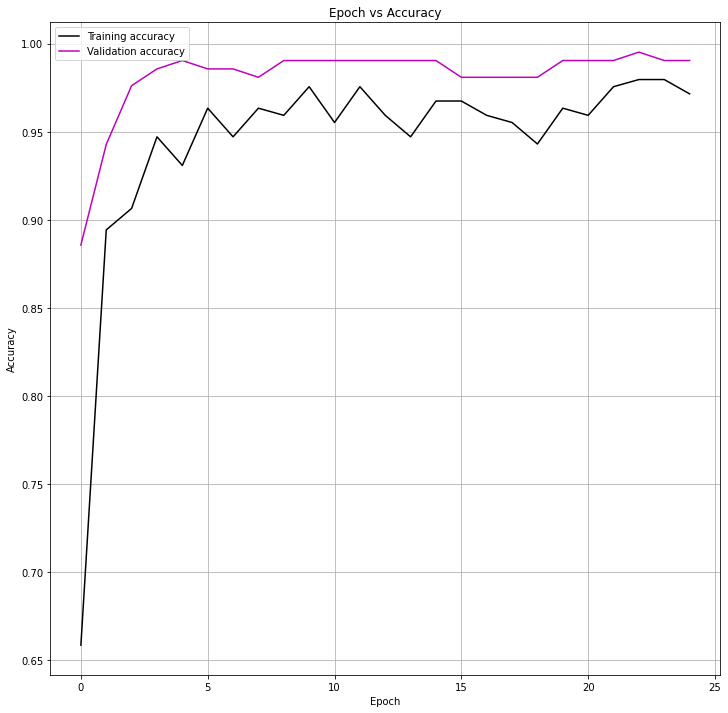

In [16]:
def train_model(model: torch.nn, 
                dataloaders: typing.Dict, 
                criterion: torch.nn, 
                optimizer: torch.optim, 
                scheduler: torch.optim, 
                num_epochs: int = 25,
              ) -> typing.Tuple:

  """
  Training module

  Parameters:
  -----------
  model: torch.nn
    NN model - Densenet finetuning model
  dataloader: typing.Dict
    Contains training and validation dataloaders in a dict
  criterion: torch.nn
      Cross entropy loss from PyTorch
  optimizers: torch.optim
    Optimizer for training
  scheduler: torch.optim
    Scheduler to reduce the learning rate after certain epochs
  num_epochs: int
    Epoch limit
  
  Return:
  -------
  model: torch.nn
    NN model - Densenet finetuning model
  val_acc_history: typing.List
    Validation accuracy per epoch
  train_acc_history: typing.List
    Training accuracy per epoch

  """

  since = time.time()
  val_acc_history = []
  train_acc_history = []
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has train and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train() # Set model to training mode
      else:
        model.eval() # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device_under_use)
        labels = labels.to(device_under_use)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward and track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          # Get model outputs and calculate loss
          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects +=torch.sum(preds == labels.data)

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == 'val':
        val_acc_history.append(epoch_acc)
      if phase == 'train':
        train_acc_history.append(epoch_acc)
        scheduler.step()


    print()
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model, val_acc_history, train_acc_history

model, val_hist, train_hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, scheduler)
plot_training_graph(train_hist, val_hist, 'accuracy')

In [17]:
# Due to lesser data. Just providing the evaluation metrics on validation set
loss, accuracy, confusion_matrix = evaluation(dataloaders["val"], model, criterion)

Size of test data:  210
Accuracy:  99.52380952380952
Confusion matrix: 
 Predicted   0    1  All
Actual                 
0          87    1   88
1           0  122  122
All        87  123  210


In [18]:
def get_mean_and_std(dataset: torch.utils.data.Dataset,
                    ) -> typing.Tuple:

    '''Compute the mean and std value of dataset
    Parameters:
    -----------
    dataset: torch.utils.data.Dataset
      Training dataset

    Return:
    -------
    mean: np.ndarray
      Mean of each channel of the images in the dataset
    std: np.ndarray
      Standard deviation of each channel of the images in the dataset 
    
    '''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std of each channel across the dataset images..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    mean = mean.numpy()
    std = std.numpy()
    print("Mean of the dataset: ", mean)
    print("Standard deviation of the dataset: ", std)
    return mean, std
  
mean, std = get_mean_and_std(dataloaders["train"].dataset)

==> Computing mean and std of each channel across the dataset images..
Mean of the dataset:  [0.35575503 0.4251811  0.55868155]
Standard deviation of the dataset:  [1.0612766 1.0685142 1.0480777]


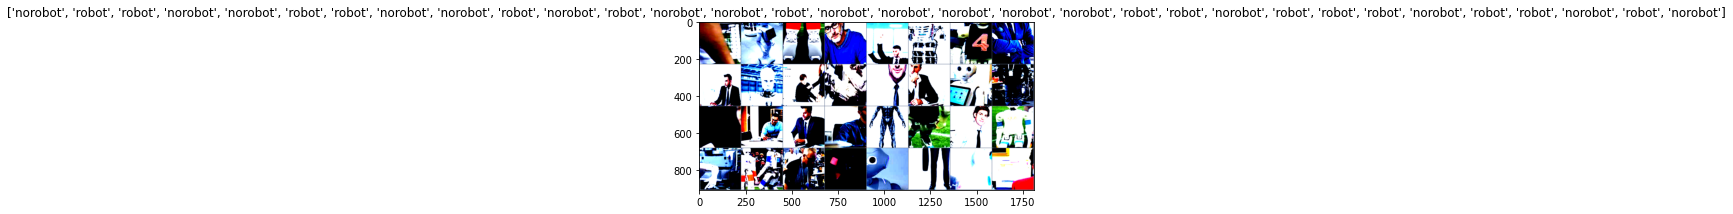

In [19]:
def imshow(inp: torch.Tensor, 
           mean: np.ndarray = mean, 
           std: np.ndarray = std,
           title: str = None,
          ) -> None:
    """Imshow for Tensor.
    
    Parameters:
    -----------
    inp: torch.Tensor
      Input image tensor
    mean: np.ndarray 
      Mean of each channel of the images in the dataset
    std: np.ndarray
      Standard deviation of each channel of the images in the dataset 
    title: str
      Label as string for the input image
          
    """
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

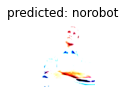

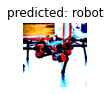

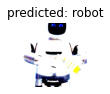

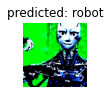

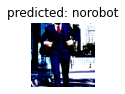

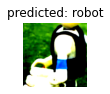

In [20]:
def visualize_model(model: torch.nn, 
                    num_images: int = 6,
                   ) -> None:

    """
    model: torch.nn
      Model whose output prediction results to be visualized (Densenet finetined)
    num_images: int
      Number of images to be shown in the visualization
    """
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        
        inputs = inputs.to(device_under_use)
        labels = labels.to(device_under_use)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu()[j])

            if images_so_far == num_images:
                return
visualize_model(model)

# Binary classification of Robot / Norobot with Mixup data augmentation

In [21]:
 def mixup_data(x: torch.Tensor,
                y: torch.Tensor,
                alpha: float = 1.0,
                use_cuda: bool = True,
                ) -> typing.Tuple:
    '''Returns mixed inputs, pairs of targets, and lambda

    Parameters:
    ----------- 
    x: torch.Tensor
      Batch of input data
    y: torch.Tensor
      Batch of target data
    alpha: float
      Co-efficient for combining the examples
    use_cuda: bool
      Flag indicating

    Return:
    -------
    mixed_x: torch.Tensor
      Virtual feature vector x = lam * x_i + (1 -  lam) * x_j
    y_a: torch.Tensor
      Label of all x_i
    y_b: torch.Tensor
      Label of all corresponding x_j
    lam: float
      Mixup hyperparameter

    '''
    # From the paper https://arxiv.org/pdf/1710.09412.pdf
    # lam \approx Beta(alpha, alpha)
    # alpha controls the strength of interpolation between feature-target pairs
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    # Index to permute
    if use_cuda:
        index = torch.randperm(batch_size).to(device_under_use)
    else:
        index = torch.randperm(batch_size)
    # Generate the virtual feature-target vectors
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion: torch.nn, 
                    pred: torch.Tensor, 
                    y_a: torch.Tensor, 
                    y_b: torch.Tensor, 
                    lam: float,
                    ) -> torch.Tensor:
    """
    Calculates loss across the two labels using linear interpolation at the lambda value. 
    
    Parameters:
    -----------
    criterion: torch.nn
      Cross entropy loss from PyTorch
    pred: torch.Tensor
      Prediction from the NN model
    y_a: torch.Tensor
      Label of all x_i
    y_b: torch.Tensor
      Label of all corresponding x_j
    lam: float
      Mixup hyperparameter

    Return:
    -------
    loss: torch.Tensor 
      Mixup criterion
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

Epoch 0/24
----------
train Loss: 0.5158 Acc: 0.8226
val Loss: 0.4207 Acc: 0.8738

Epoch 1/24
----------
train Loss: 0.4390 Acc: 0.8517
val Loss: 0.4415 Acc: 0.8654

Epoch 2/24
----------
train Loss: 0.3232 Acc: 0.8985
val Loss: 0.3980 Acc: 0.8710

Epoch 3/24
----------
train Loss: 0.3727 Acc: 0.8807
val Loss: 0.4860 Acc: 0.8366

Epoch 4/24
----------
train Loss: 0.3486 Acc: 0.8663
val Loss: 0.2859 Acc: 0.8951

Epoch 5/24
----------
train Loss: 0.4853 Acc: 0.8316
val Loss: 0.4560 Acc: 0.8562

Epoch 6/24
----------
train Loss: 0.2456 Acc: 0.9056
val Loss: 0.2968 Acc: 0.9166

Epoch 7/24
----------
train Loss: 0.4202 Acc: 0.8514
val Loss: 0.3034 Acc: 0.9096

Epoch 8/24
----------
train Loss: 0.2925 Acc: 0.8959
val Loss: 0.2475 Acc: 0.9264

Epoch 9/24
----------
train Loss: 0.3444 Acc: 0.8838
val Loss: 0.2884 Acc: 0.9162

Epoch 10/24
----------
train Loss: 0.3951 Acc: 0.8784
val Loss: 0.3765 Acc: 0.8827

Epoch 11/24
----------
train Loss: 0.3447 Acc: 0.8879
val Loss: 0.4024 Acc: 0.8697

Ep

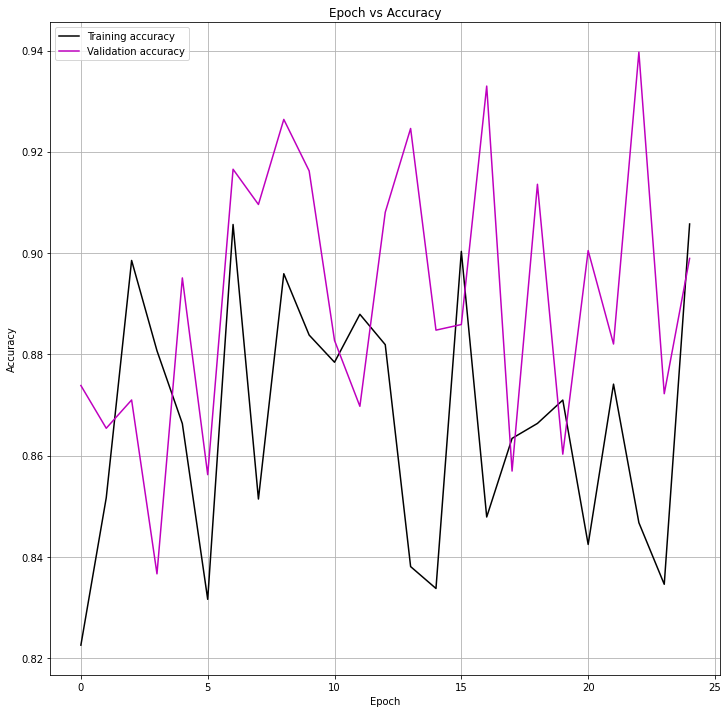

In [22]:
def train_model(model: torch.nn, 
                dataloaders: typing.Dict, 
                criterion: torch.nn, 
                optimizer: torch.optim, 
                scheduler: torch.optim, 
                num_epochs: int = 25,
                ) -> typing.Tuple:

  """
  Training module

  Parameters:
  -----------
  model: torch.nn
    NN model - Densenet finetuning model
  dataloader: typing.Dict
    Contains training and validation dataloaders in a dict
  criterion: torch.nn
      Cross entropy loss from PyTorch
  optimizers: torch.optim
    Optimizer for training
  scheduler: torch.optim
    Scheduler to reduce the learning rate after certain epochs
  num_epochs: int
    Epoch limit
  
  Return:
  -------
  model: torch.nn
    NN model - Densenet finetuning model
  val_acc_history: typing.List
    Validation accuracy per epoch
  train_acc_history: typing.List
    Training accuracy per epoch

  """

  
  since = time.time()
  val_acc_history = []
  train_acc_history = []
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch, num_epochs - 1))
    print('-' * 10)

    # Each epoch has train and validation phase
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train() # Set model to training mode
      else:
        model.eval() # Set model to evaluate mode

      running_loss = 0.0
      running_corrects = 0

      # Iterate over data
      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device_under_use)
        targets = labels.to(device_under_use)

        inputs, targets_a, targets_b, lam = mixup_data(inputs, targets,
                                                       0.5)
        inputs, targets_a, targets_b = map(torch.autograd.Variable,(inputs,
                                                      targets_a, targets_b))
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward and track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          # Get model outputs and calculate loss
          outputs = model(inputs)
          loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += (lam * preds.eq(targets_a.data).cpu().sum().float()
                    + (1 - lam) * preds.eq(targets_b.data).cpu().sum().float())

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == 'val':
        val_acc_history.append(epoch_acc)
      if phase == 'train':
        train_acc_history.append(epoch_acc)
        scheduler.step()

    print()
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model, val_acc_history, train_acc_history

model, val_hist, train_hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, scheduler)
plot_training_graph(train_hist, val_hist, 'accuracy')

In [23]:
# Due to lesser data. Just providing the evaluation metrics on validation set
loss, accuracy, confusion_matrix = evaluation(dataloaders["val"], model, criterion)

Size of test data:  210
Accuracy:  97.61904761904762
Confusion matrix: 
 Predicted   0    1  All
Actual                 
0          84    4   88
1           1  121  122
All        85  125  210


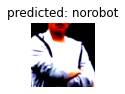

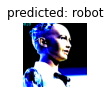

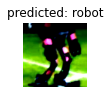

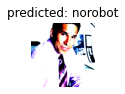

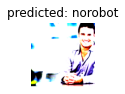

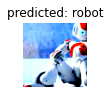

In [24]:
visualize_model(model)

# Acknowledgement

Images for dataset generation have been done using the following sources:

1. YouTube video frames of the following videos:

* https://www.youtube.com/watch?v=JdP0AG0FqwY
* https://www.youtube.com/watch?v=6ldHWWHfeBc&t=5s
* https://www.youtube.com/watch?v=WJKc56uUuF8
* https://www.youtube.com/watch?v=RG205OwGdSg
* https://www.youtube.com/watch?v=yVdB_0ry53o
* https://www.youtube.com/watch?v=TWNvSHpMrSM
* https://www.youtube.com/watch?v=UsmBD2_3FH8
* https://www.youtube.com/watch?v=WGKo_6IkFBY
* https://www.youtube.com/watch?v=G6xE7uWt6Fo&t=1s
* https://www.youtube.com/watch?v=G9llFqAwI-8&t=17s
* https://www.youtube.com/watch?v=t8Ni5cB9FCc&t=21s
* https://www.youtube.com/watch?v=CLkcznptenE
* https://www.youtube.com/watch?v=-FQOZTsEA1Y
* https://www.youtube.com/watch?v=hkZAMO0y0Hs
* https://www.youtube.com/watch?v=9saVpA3wIbU
* https://www.youtube.com/watch?v=RC7ZNXclWWY

The videos were paused at different point in time and robot and norobot (mostly human and football) images are snipped. Football is included in norobot because in most of the frames football is closely present to the robot surface. 

2. Google search image results for the keywords: human, office human, robots, humanoid robots. The images are downloaded using Image Downloader plugin.

3. The Session 5 lab code presented by Hafez Farazi at CudaVision: Learning Vision Systems on Graphics Cards Lab has been re-used.

# References

[1] Zhang, Hongyi, Moustapha Cisse, Yann N. Dauphin, and David Lopez-Paz. "mixup: Beyond empirical risk minimization." arXiv preprint arXiv:1710.09412 (2017).

[2] Zhang, Hongyi, Moustapha Cisse, Yann N. Dauphin, and David Lopez-Paz, 'Mixup-CIFAR10', Facebook AI Research, Available at: https://github.com/facebookresearch/mixup-cifar10, Accessed on: 14.12.2020

[3] Hafez Farazi, 'Transfer learning - Code block - Session 5, CudaVision: Learning Vision Systems on Graphics Cards Lab, lecture code', Accessed on: 14.12.2020.
